<h1><center> Paw Print <center><h1>
<img src='images/paw_print.png' width=200/>

# Project Overview
---
This project aims to create a model that can accurately predict a dog's breed given an image. Additionally it will output the top 5 breed predictions and the breed traits (including temperament, size, energy level, trainability, etc) of the predicted breed. 

Using Tensorflow's Pre-Trained Convolutional Neural Networks we were able to produce a model that had a prediction accuracy of 78% on test images. With further analysis we have determined that, 94% of the time, our model will classify an image as the correct breed within the top 5 predictions.

# Business Understanding
---
I am working with a local Animal Shelter in Seattle to create a model that can predict a dogs breed given an image. Every year over 3 million dogs end up in animal shelters. A study done in 2013 showed that shelter staff correctly visually identify breeds 67% of the time, and that accuracy was exponentially lower for dogs that are mixed breeds. Additionally the number one question asked by people looking for dogs in a shelter is "what breed is that dog?". Creating a model that can predict a dogs breed given an image can be increase identification accuracy and save time and resources. Additionally, an accurate breed prediction has the potential to lead to a higher rate of dog adoptions within shelters, which could save thousands of dogs lives every year. 

Examples of types of visual identification that animal shelters use to classify dogs:
- Color
- Size
- Fur length
- Distinguishable features/markings (ex: Rhodesian Ridgebacks have a ridge of fur going in the oposite direction on their backs)
- Ears: Floppy or upright

Overall, creating a CNN model that can predict a dogs breed can be immensely useful for animal shelters to save time and resources, increase identification accuracy, and potentially lead to an increase in dog adoptions.

Sources: 
- https://www.smithsonianmag.com/smart-news/genetic-testing-shows-animal-shelters-often-misidentify-dogs-breeds-180970136/
- https://earthsky.org/earth/guess-shelter-dog-breed-genotype-study/

## Data Understanding
---
AKC Dog Breed Traits: This dataset contains dog breed traits (temperament, height, weight, trainability, energy level, etc) for 277 dog breeds. This dataset comes from https://github.com/tmfilho/akcdata/blob/master/data/akc-data-latest.csv and has been pre-processed in the [dog_breed_preprocessing.ipynb](https://github.com/hannah-schurman/dog-breed-identification/blob/main/dog_breed_preprocessing.ipynb) notebook so that the dog breed labels are compatible with those from our images. 

Dog Breed Images and Labels: This dataset contains 10,222 images of dogs from 120 different breeds, along with a dataframe containing each image name and their corresponding breed. This dataset comes from Kaggle https://www.kaggle.com/c/dog-breed-identification.

# Data Preparation

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.image import imread

import warnings

#sci kit learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# tensorflow imports
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, regularizers, models, optimizers, Sequential

from tensorflow.keras.applications import MobileNetV2, InceptionResNetV2
import tensorflow_hub as hub

In [2]:
# read in csv file containing file names and breeds
breed_df = pd.read_csv('data/dog-breed-identification/labels.csv')

In [3]:
breed_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breed_df[breed_df['breed'] == 'dhole']

,id,breed
42,011e06760794850c40f23d6426c40774,dhole
133,032620ae0f847d957d94d1fd76cb17e8,dhole
257,060112a1a77217039de21f7d0963929d,dhole
372,08ea655aa168d87806340c336d07f1c9,dhole
516,0c71338af3f3a8c068ec28b5f6b8f8ae,dhole
...,...,...
9181,e6898f5cc43bb4a30970f2d2210fdb9a,dhole
9317,e9efc5edbe14eb6375a64b37db8b36df,dhole
9611,f1a18e29959bc5af735ebb5045f91b25,dhole
9618,f1f03709a6fb351e6255cabc277c5fc4,dhole


In [5]:
# both columns are object type
breed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [6]:
# number of images per breed range from 66-126
breed_df['breed'].value_counts() 

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [7]:
# get the directory for the training images
train_dir = 'data/dog-breed-identification/train/'

In [8]:
# add directory path and .jpg to each image name in dataframe  to make readable
breed_df['id'] = train_dir+breed_df['id']+'.jpg'

#### Read in final AKC Dataset. This dataset has been preprocessed in the [preprocessing notebook](https://github.com/hannah-schurman/dog-breed-identification/blob/main/dog_breed_preprocessing.ipynb)

In [9]:
# read in AKC breed dataset for later evaluation
akc_breeds = pd.read_csv('data/akc_breeds_final.csv')

In [10]:
akc_breeds

,Breed,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,affenpinscher,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,afghan_hound,"Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,airedale,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,malamute,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly
4,boston_bull,"Loyal, Self-Confident",NaN,50.80,63.50,27.215542,45.359237,10.0,12.0,Foundation Stock Service,0.2,Occasional Bath/Brush,0.6,Seasonal,0.8,Energetic,0.6,Agreeable,0.6,Alert/Responsive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,whippet,"Affectionate, Playful, Calm",61,45.72,55.88,11.339809,18.143695,12.0,15.0,Hound Group,0.2,Occasional Bath/Brush,0.4,Occasional,0.6,Regular Exercise,0.4,Independent,0.4,Reserved with Strangers
116,wire-haired_fox_terrier,"Confident, Alert, Gregarious",101,38.10,38.10,6.803886,8.164663,12.0,15.0,Terrier Group,0.4,Weekly Brushing,0.2,Infrequent,0.6,Regular Exercise,0.6,Agreeable,0.6,Alert/Responsive
117,mexican_hairless,"Loyal, Alert, Calm",140,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,Occasional Bath/Brush,0.2,Infrequent,0.8,Energetic,0.6,Agreeable,0.6,Alert/Responsive
118,yorkshire_terrier,"Affectionate, Sprightly, Tomboyish",10,17.78,20.32,3.175147,3.175147,11.0,15.0,Toy Group,1.0,Specialty/Professional,0.2,Infrequent,0.6,Regular Exercise,0.2,May be Stubborn,0.8,Friendly


### Get the top 10 breeds and visualize a sample set of images

In [11]:
# get top 10 dog breeds
top_10 = breed_df['breed'].value_counts()[:10]
top_10

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

In [12]:
# get the top 10 dog breeds for visualization
top_breed_images = []

for breed in top_10.index:
    breed_img = breed_df[breed_df['breed'] == breed].iloc[np.random.randint(len(breed_df[breed_df['breed'] == breed]))]
    top_breed_images.append(breed_img)

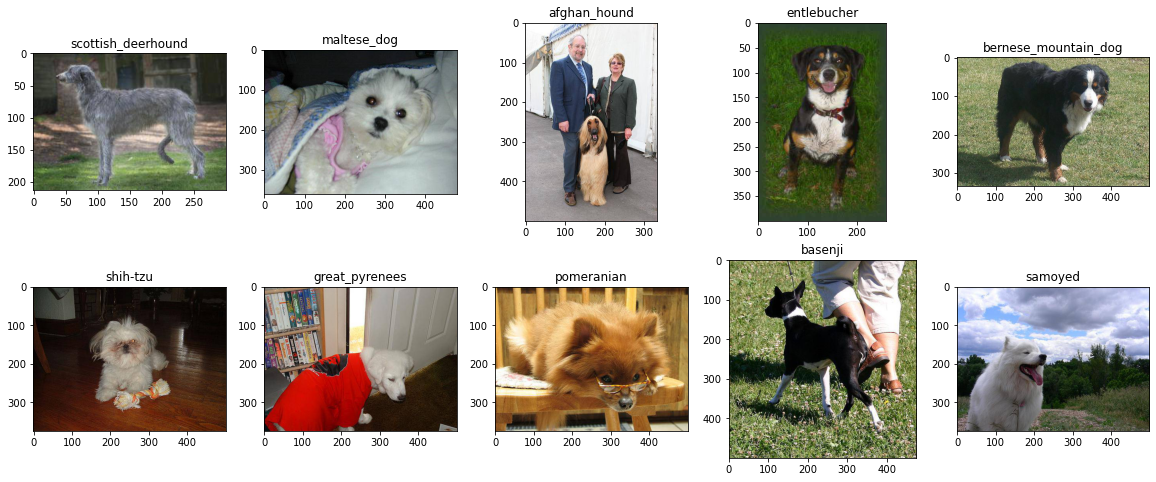

In [13]:
# visualize example images of the top 10 dog breeds
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

x = 0
for i in range(2):
    for j in range(5):
        im = plt.imread(top_breed_images[x]['id'])
        axes[i][j].imshow(im)
        axes[i][j].plot()
        axes[i][j].set_title(top_breed_images[x]['breed'])
        x += 1

### Split data frame into train and validation and use image data generator to create augmented images for modeling

In [14]:
# split into train and val (25% val)
train_df, val = train_test_split(breed_df, test_size=0.25, random_state=42)

In [15]:
# split val into val and test (10% test)
val_df, test_df = train_test_split(val, test_size=0.10, random_state=42, stratify=val['breed'])

In [16]:
# use data augmentation on train split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_data = train_datagen.flow_from_dataframe( 
    train_df,
    x_col='id',
    y_col='breed',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32)

# do not use data augmentation on validation split
val_datagen = ImageDataGenerator(rescale = 1./255)
val_data = val_datagen.flow_from_dataframe(val_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)

# do not use data augmentation on test split
test_datagen = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_dataframe(test_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)


Found 7666 validated image filenames belonging to 120 classes.
Found 2300 validated image filenames belonging to 120 classes.
Found 256 validated image filenames belonging to 120 classes.


In [17]:
breed_classes = train_data.class_indices

In [18]:
breed_classes

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [19]:
train_images, train_labels = next(train_data)
val_images, val_labels = next(val_data)
test_images, test_labels = next(test_data)

In [20]:
train_images[0].shape

(224, 224, 3)

pekinese


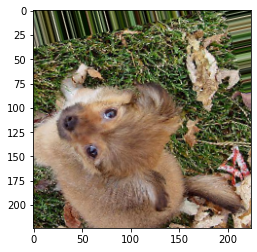

In [21]:
# show an example of how data augmentation affects images
plt.imshow(train_images[0]);
print(list(breed_classes)[np.argmax(train_labels[0])])

### Image Augmentation Example (Rotation Range)

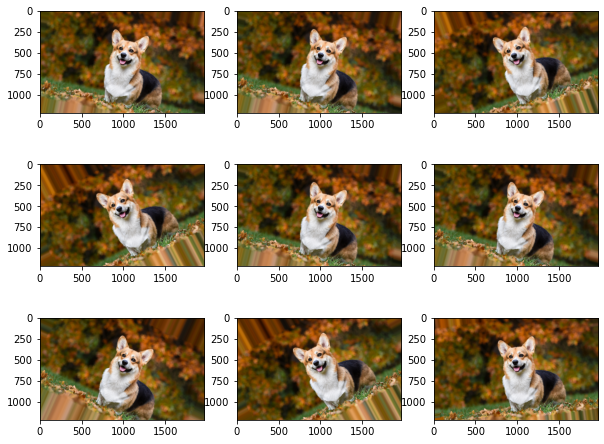

In [22]:
# create a function that shows and example of rotational augmentation
def horizontal_augmentation(img_path):
    img = load_img(img_path)
    data = img_to_array(img)
    test = np.expand_dims(data, 0)

    datagen = ImageDataGenerator(rotation_range = 30)
    test_image = datagen.flow(test, batch_size=1)
    
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10,8))

    x = 0
    for i in range(3):
        for j in range(3):
            batch = test_image.next()
            image = batch[0].astype('uint8')
            axes[i][j].imshow(image)    

horizontal_augmentation('data/test_dogs/corgi.jpg')

Source: Above function for Image Augmentation was referenced from a blog on Machine Learning Mastery (https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)

# Modeling
---

In [23]:
# define early stopping so our models will stop running if they're performance tapers off
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [24]:
def plot_model(results):
    """
    This function plots how the accuracy and loss for train and val datasets progress over each epoch

    Parameters
    ----------
    Results: This takes in the results from a model being fit

    Returns
    -------
    No Returns: Just plots graph within method call

    """
    
    history=results.history

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    ax1.plot(history['loss'], label='Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.grid(False)
    ax1.legend()

    ax2.plot(history['acc'], label = 'Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.grid(False)
    ax2.legend();

In [25]:
def plot_confusion_matrix(model, test_images, test_labels):
    """
    This function plots a confusion matrix for how 'model' performs on the 'test' input

    Parameters
    ----------
    model: Model that has been compiled and fit
    test_images: dataset of images that are preprocessed and ready for evaluation
    test_labels: corresponding labels for each test image

    Returns
    -------
    No Returns: Plots confusion matrix within the function
    """
    predictions = np.array(model.predict(test_images))

    y_pred = [np.argmax(pred, -1) for pred in predictions]
    y_true = [np.argmax(label) for label in test_labels]
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.get_cmap('Blues'), ax=ax)
    ax.grid(False)
    #ax.show();

### Baseline Model: Tensorflow Pre-trained MobileNetV2 model
Using MobileNetV2 because it is the most efficient model to use in a mobile app. This is becasue it is faster and smaller than other models. It can be known to sacrifice some accuracy, though I tried other models and MobileNetV2 was the most accurate on this data. 

In [26]:
# set up MobileNetV2 model, add layers to sequential and compile
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
baseline_model = models.Sequential()

baseline_model.add(mobilenet)
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(120, activation='softmax'))

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [27]:
# fit model on training and run with validation data. Chose 10 epochs because that seemed to be a point of taper. 
# defined early stopping if no improvement
baseline_results = baseline_model.fit(train_data, 
                                      validation_data = val_data, 
                                      epochs = 10, 
                                      callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 185s 773ms/step - loss: 14.3798 - acc: 0.4301 - val_loss: 12.7483 - val_acc: 0.5626
Epoch 2/10
240/240 [==============================] - 179s 746ms/step - loss: 8.9715 - acc: 0.6624 - val_loss: 14.0203 - val_acc: 0.6122
Epoch 3/10
240/240 [==============================] - 177s 738ms/step - loss: 6.6553 - acc: 0.7451 - val_loss: 15.5284 - val_acc: 0.6170
Epoch 4/10
240/240 [==============================] - 186s 776ms/step - loss: 5.8762 - acc: 0.7906 - val_loss: 14.7709 - val_acc: 0.6343
Epoch 5/10
240/240 [==============================] - 186s 777ms/step - loss: 5.3033 - acc: 0.8107 - val_loss: 16.5563 - val_acc: 0.6339
Epoch 6/10
240/240 [==============================] - 191s 795ms/step - loss: 4.8617 - acc: 0.8302 - val_loss: 16.4443 - val_acc: 0.6365


In [28]:
test_eval = baseline_model.evaluate(test_data)

8/8 [==============================] - 4s 475ms/step - loss: 17.1203 - acc: 0.6367


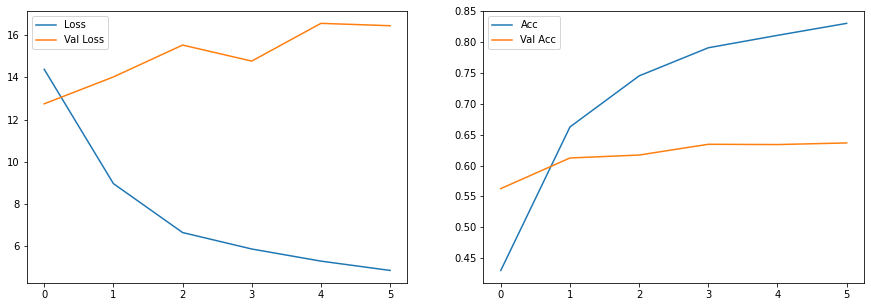

In [29]:
plot_model(baseline_results)

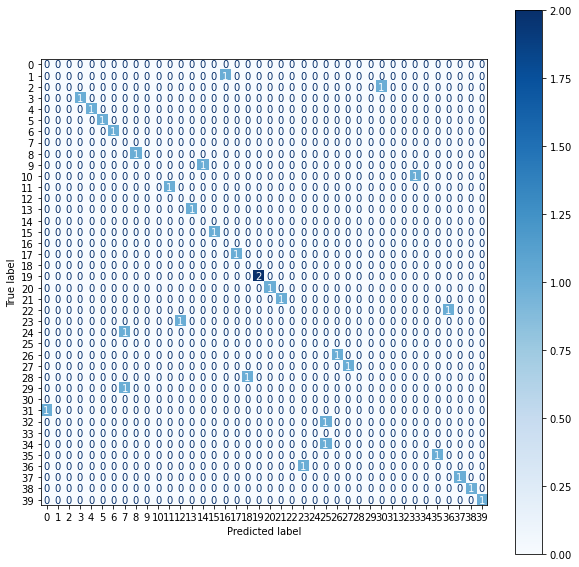

In [30]:
plot_confusion_matrix(baseline_model, test_images, test_labels)

### Tuned MobileNetV2 model
We can see by our validation loss and accuracy that our model is clearly overfitting on our training data, so lets add some other layers and dropout to see if we can fix that

In [31]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model = models.Sequential()

trained_model.add(mobilenet)
trained_model.add(layers.GlobalAveragePooling2D())
trained_model.add(layers.Dense(512, activation = 'relu'))
trained_model.add(layers.Dropout(0.5))
trained_model.add(layers.Dense(120, activation='softmax'))

trained_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [32]:
# fit model on training and run with validation data. Chose 10 epochs because that seemed to be a point of taper. 
# defined early stopping if no improvement
trained_results = trained_model.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 190s 790ms/step - loss: 2.6376 - acc: 0.3656 - val_loss: 1.1816 - val_acc: 0.6622
Epoch 2/10
240/240 [==============================] - 190s 791ms/step - loss: 1.4610 - acc: 0.5891 - val_loss: 0.9963 - val_acc: 0.7030
Epoch 3/10
240/240 [==============================] - 189s 788ms/step - loss: 1.2678 - acc: 0.6342 - val_loss: 0.9820 - val_acc: 0.7100
Epoch 4/10
240/240 [==============================] - 190s 791ms/step - loss: 1.1360 - acc: 0.6685 - val_loss: 0.9583 - val_acc: 0.7117
Epoch 5/10
240/240 [==============================] - 189s 787ms/step - loss: 1.0650 - acc: 0.6861 - val_loss: 0.9574 - val_acc: 0.7091
Epoch 6/10
240/240 [==============================] - 195s 810ms/step - loss: 0.9936 - acc: 0.6936 - val_loss: 0.9927 - val_acc: 0.7074
Epoch 7/10
240/240 [==============================] - 199s 829ms/step - loss: 0.9213 - acc: 0.7242 - val_loss: 0.9425 - val_acc: 0.7222
Epoch 8/10
240/240 [============================

In [33]:
# evalute how model performs on test holdout data
test_eval = trained_model.evaluate(test_data)

8/8 [==============================] - 4s 503ms/step - loss: 1.0594 - acc: 0.6953


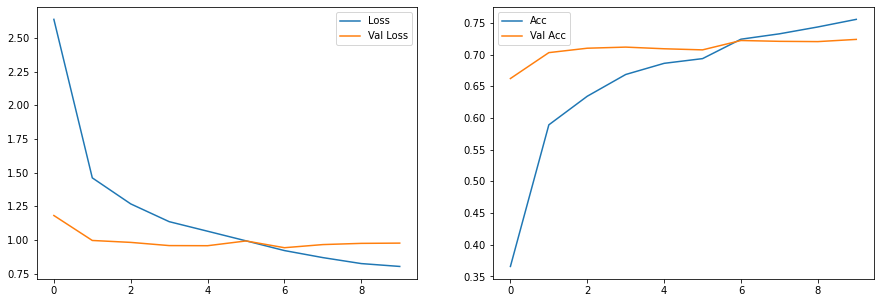

In [34]:
plot_model(trained_results)

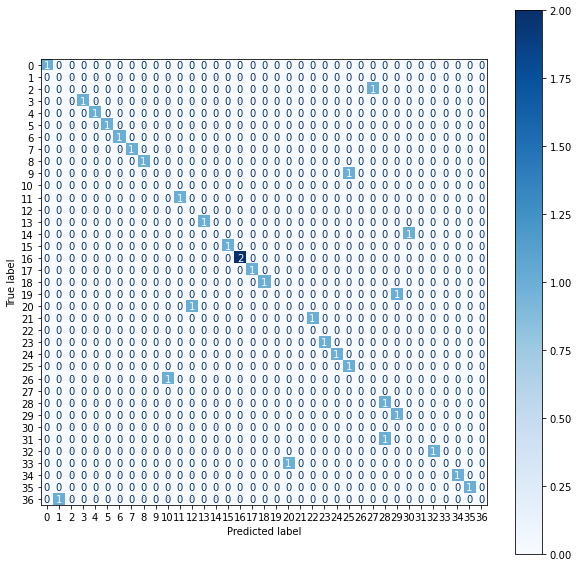

In [35]:
plot_confusion_matrix(trained_model, test_images, test_labels)

Our tuned model showed a slight improvement from our baseline model in validation accuracy and loss as well as in minimizing training overfitting. Lets test out some further tuning to see if we are able to improve the model even further

### Try adding BatchNormalization to see if that improves our model at all

In [36]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model2 = models.Sequential()

trained_model2.add(mobilenet)
trained_model2.add(layers.GlobalAveragePooling2D())
trained_model2.add(layers.Dense(512, activation = 'relu'))
trained_model2.add(layers.BatchNormalization())
trained_model2.add(layers.Dropout(0.5))
trained_model2.add(layers.Dense(120, activation='softmax'))

trained_model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [37]:
# fit model on training and run with validation data. Chose 10 epochs because that seemed to be a point of taper. 
# defined early stopping if no improvement
trained_results2 = trained_model2.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 205s 855ms/step - loss: 2.3400 - acc: 0.4363 - val_loss: 1.1559 - val_acc: 0.6670
Epoch 2/10
240/240 [==============================] - 200s 834ms/step - loss: 1.2512 - acc: 0.6421 - val_loss: 1.0461 - val_acc: 0.6891
Epoch 3/10
240/240 [==============================] - 208s 866ms/step - loss: 1.0777 - acc: 0.6878 - val_loss: 1.0003 - val_acc: 0.6987
Epoch 4/10
240/240 [==============================] - 206s 858ms/step - loss: 0.9243 - acc: 0.7245 - val_loss: 1.0178 - val_acc: 0.7009
Epoch 5/10
240/240 [==============================] - 205s 853ms/step - loss: 0.8782 - acc: 0.7385 - val_loss: 1.0141 - val_acc: 0.6939
Epoch 6/10
240/240 [==============================] - 204s 851ms/step - loss: 0.7843 - acc: 0.7570 - val_loss: 1.0164 - val_acc: 0.7035
Epoch 7/10
240/240 [==============================] - 204s 850ms/step - loss: 0.7234 - acc: 0.7801 - val_loss: 1.0163 - val_acc: 0.7026
Epoch 8/10
240/240 [============================

In [38]:
test_eval = trained_model2.evaluate(test_data)

8/8 [==============================] - 4s 470ms/step - loss: 1.0933 - acc: 0.6992


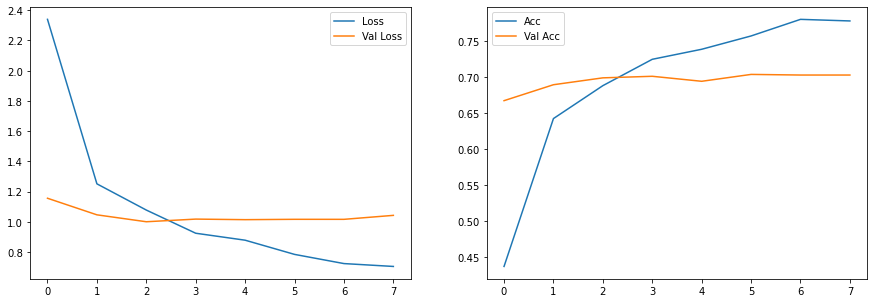

In [39]:
plot_model(trained_results2)

We have significantly reduced our loss and we have improved accuracy but we are still seeing overfitting. Lets use the tensorflow hub version of MobileNetV2 to see if we can improve accuracy more and reduce overfitting

### Tensorflow Hub MobileNet V2 

In [46]:
# saved model from https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5 to data folder
mobilenet_model = hub.KerasLayer('data/imagenet_mobilenet_v2_130_224_classification_5/')

mobilenet_hub = models.Sequential([mobilenet_model, 
                          layers.Dense(units=120, activation="softmax")])

mobilenet_hub.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics = ['acc'])


In [47]:
# fit model on training and run with validation data. Chose 10 epochs because that seemed to be a point of taper. 
# defined early stopping if no improvement
hub_results = mobilenet_hub.fit(train_data,
                        epochs=10,
                        validation_data=val_data,
                        callbacks=early_stopping)

Epoch 1/10
240/240 [==============================] - 215s 895ms/step - loss: 1.8577 - acc: 0.5547 - val_loss: 0.8362 - val_acc: 0.7530
Epoch 2/10
240/240 [==============================] - 203s 846ms/step - loss: 0.7215 - acc: 0.7859 - val_loss: 0.7436 - val_acc: 0.7743
Epoch 3/10
240/240 [==============================] - 206s 858ms/step - loss: 0.5393 - acc: 0.8343 - val_loss: 0.7596 - val_acc: 0.7722
Epoch 4/10
240/240 [==============================] - 206s 858ms/step - loss: 0.4312 - acc: 0.8637 - val_loss: 0.7731 - val_acc: 0.7709
Epoch 5/10
240/240 [==============================] - 210s 875ms/step - loss: 0.3584 - acc: 0.8849 - val_loss: 0.7704 - val_acc: 0.7713
Epoch 6/10
240/240 [==============================] - 208s 866ms/step - loss: 0.3348 - acc: 0.8900 - val_loss: 0.7836 - val_acc: 0.7800
Epoch 7/10
240/240 [==============================] - 208s 865ms/step - loss: 0.2964 - acc: 0.9050 - val_loss: 0.7593 - val_acc: 0.7804


In [48]:
test_eval = mobilenet_hub.evaluate(test_data)

8/8 [==============================] - 4s 521ms/step - loss: 0.8927 - acc: 0.7852


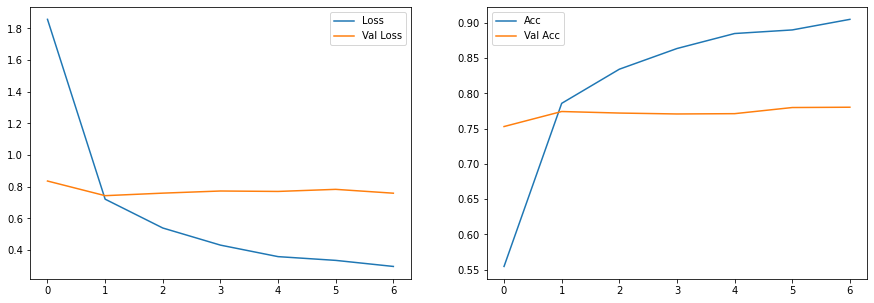

In [49]:
plot_model(hub_results)

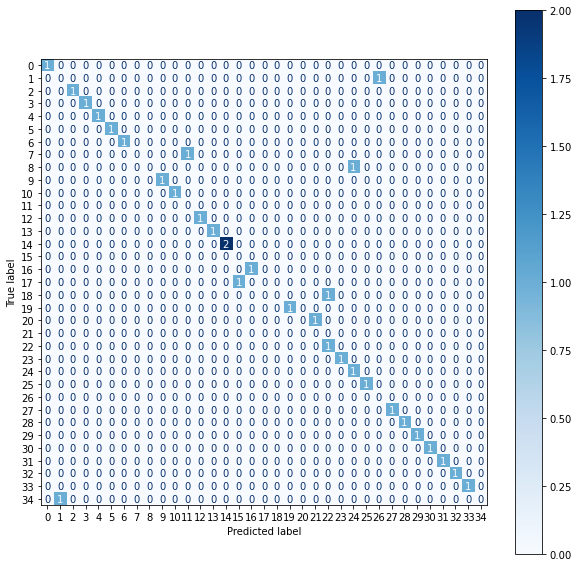

In [50]:
plot_confusion_matrix(mobilenet_hub, test_images, test_labels)

#### MobileNetV2 Hub gave us the best results thus far. Let's test out one more type of pre-trained CNN model to see how it compares with loss, accuracy, and overfitting

### InceptionResNetV2
Test out another pre-trained model to see how it's performance compares to MobileNetV2

In [51]:
inception = InceptionResNetV2(include_top = False, weights ='imagenet', input_shape = (224,224,3))
inception.trainable = False

inception_model = models.Sequential()
inception_model.add(inception)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(layers.Dense(512,activation='relu'))
inception_model.add(layers.Dropout(0.5))

inception_model.add(layers.Dense(120,activation = 'softmax'))

inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['acc'])

In [52]:
# fit model on training and run with validation data. Chose 5 epochs because model runs very slowly
# also validation accuracy improvement showed to have tapered by around 5 epochs
# defined early stopping if no improvement
inception_report = inception_model.fit(train_data,
                    epochs = 5,
                    validation_data = val_data,
                    callbacks = early_stopping)

Epoch 1/5
240/240 [==============================] - 585s 2s/step - loss: 1.6444 - acc: 0.6404 - val_loss: 0.6869 - val_acc: 0.8043
Epoch 2/5
240/240 [==============================] - 910s 4s/step - loss: 1.0087 - acc: 0.7459 - val_loss: 0.6641 - val_acc: 0.8170
Epoch 3/5
240/240 [==============================] - 573s 2s/step - loss: 0.9158 - acc: 0.7566 - val_loss: 0.6609 - val_acc: 0.8117
Epoch 4/5
240/240 [==============================] - 620s 3s/step - loss: 0.8982 - acc: 0.7619 - val_loss: 0.6619 - val_acc: 0.8174
Epoch 5/5
240/240 [==============================] - 598s 2s/step - loss: 0.8540 - acc: 0.7707 - val_loss: 0.6768 - val_acc: 0.8196


In [53]:
# evaluate model on test holdout data
test_eval = inception_model.evaluate(test_data)

8/8 [==============================] - 13s 2s/step - loss: 0.6216 - acc: 0.8047


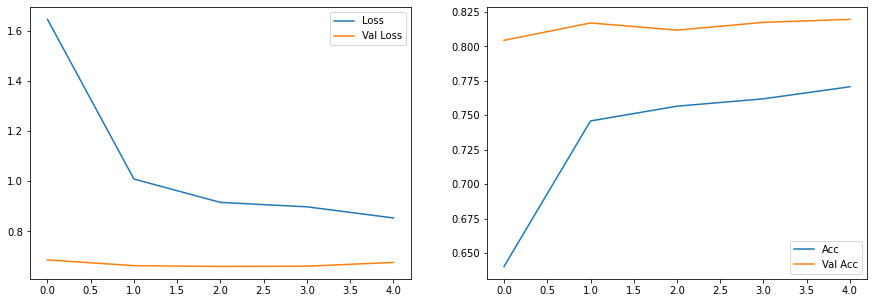

In [54]:
plot_model(inception_report)

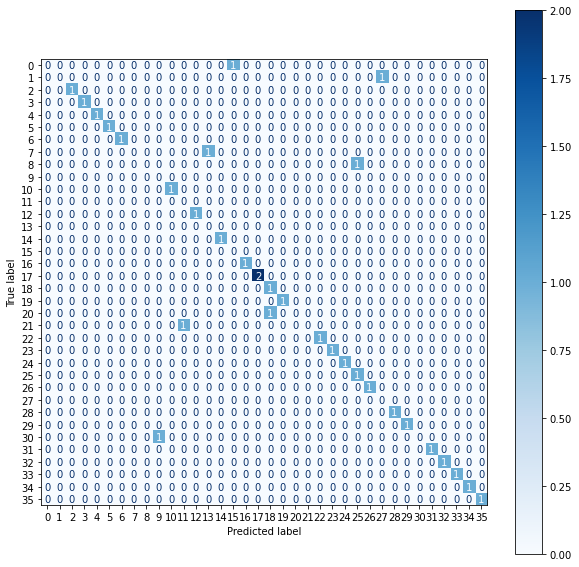

In [55]:
plot_confusion_matrix(inception_model, test_images, test_labels)

### InceptionResNetV2 gives higher validation accuracy and lower validation loss, but performed worse on training accuracy and loss. When model was tested on sample images, it correctly identified breeds at similar rate as MobileNetV2, but at much lower percentages. (MobileNetV2 Hub would categorize the correct breed at 91% and InceptionResNetV2 would categorize correctly but only at 23%). We will stick with MobileNetV2 as our final model because of it's relatively high accuracy as well as it's speed. 

In [56]:
# save model
# mobilenet_hub.save('data/models/mobilenet_hub.tf')


In [79]:
# React native cannot recognize mobilenet hub models. Use next best non-hub mobilenet model for app.
# trained_model.save('data/models/mobilenet.h5')

# Evaluation
---
We will use MobileNetV2 Hub for our final model. Below we will create a function that plots predictions and gives breed traits for any input test images. 

In [58]:
# load saved model
saved_mobilenet = models.load_model('data/models/mobilenet_hub.tf')

In [59]:
saved_mobilenet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense_5 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 5,508,697
Non-trainable params: 44,256
_________________________________________________________________


In [60]:
test_eval = saved_mobilenet.evaluate(test_data)

8/8 [==============================] - 4s 507ms/step - loss: 0.8937 - acc: 0.7812


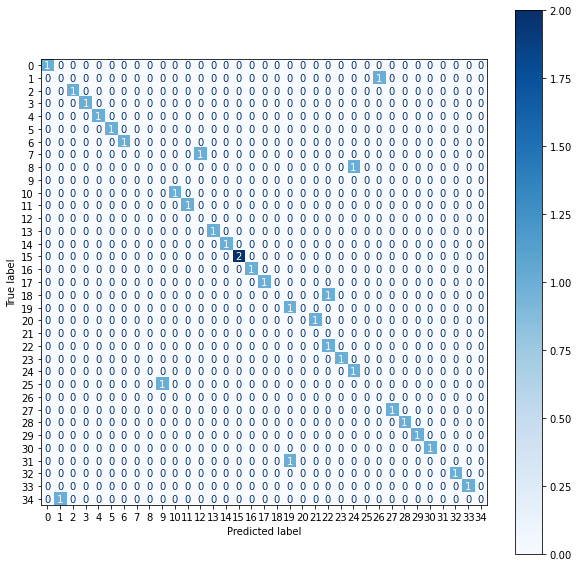

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
plot_confusion_matrix(saved_mobilenet, test_images, test_labels)

### Below we have created some functions that allow us to input a single image from a file, convert it to a usable format for our model, plug the image into our model, and output an image prediction and corresponding breed traits

In [62]:
def get_temperament(prediction):
    """
    This function prints out corresponding breed information (name, temperament, height, weight, energy level, popularity)
    for the input prediction

    Parameters
    ----------
    prediction: function takes in a string which corresponds to an images predicted breed

    Returns
    -------
    No Returns: Prints out breed traits for the predicted breed
    """
    breed_name = prediction.replace('_', ' ').title()
    
    # get breed information from akc_breeds dataset
    breed = akc_breeds[akc_breeds['Breed'] == prediction]
    temp = breed['temperament'].values[0]
    pop = breed['popularity'].values[0]
    avg_height = (breed['min_height'].values[0] + breed['max_height'].values[0]) / 2
    avg_weight = (breed['min_weight'].values[0] + breed['max_weight'].values[0]) / 2
    energy = breed['energy_level_value'].values[0]*10
    group = breed['group'].values[0]
    
    # print out breed information
    print(f"Breed: {breed_name}")
    print(f"Breed Group: {group}")
    print(f"Temperament: {temp}")
    print(f"Popularity: {pop}/277")
    print(f"Average Height: {round(avg_height, 2)} inches")
    print(f"Average Weight: {round(avg_weight, 2)} lbs")
    print(f"Energy Level: {int(energy)}/10")


In [63]:
def predict_input(image_path, model, label='None', top_5 = False):
    """
    This function takes in a test image, reshapes the image, runs the image through the model to get a breed prediction,
    plots the prediction, gets personality traits, plots the top 5 predictions, and has the extended option to plot 
    example images of the top 5 breed predictions

    Parameters
    ----------
    image_path: directory path to the test image
    model: model that we are evaluating test image on
    label: optional parameter: corresponding breed label to test for accuracy
    top_5: optional parameter: option for whether we want example images of the top 5 breed predictions printed out

    Returns
    -------
    prediction: returns all the predicted probabilities for the image that is output from the model
    """
    if label == 'None' or label not in breed_classes:
        label == 'None'
    
    # turn breed classes into a list
    breeds = list(breed_classes)
        
    #plot image
    plt.figure()
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    
    #predict image
    photo = load_img(test_dog, target_size=(224, 224))
    photo = img_to_array(photo)/255
    reshape_image = np.reshape(photo, [1, photo.shape[0], photo.shape[1], 3])
    predictions = np.array(model.predict(reshape_image))
    predicted_class = np.argmax(predictions, -1)
        
    # plot prediction class and percentage
    plt.title(f"Breed Prediction: {np.max(predictions)*100:.1f}% {breeds[predicted_class[0]]}\n", fontsize=15)

    # get top 5 breed predictions
    top_preds = predictions[0].argsort()[-5:][::-1]
    top_breeds = []
    for n in top_preds:
        top_breeds.append([breeds[n], predictions[0][n]])
        
    # plot top 5 predictions and their percentages 
    color = ['green' if (x[0] == label) else 'grey' for x in top_breeds]
    
    plt.figure()
    plt.bar([n[0] for n in top_breeds], [m[1] for m in top_breeds], color=color)
    plt.xticks(rotation=45)
    
    
    #get the top 5 dog breeds for visualization
    if top_5 == True:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15, 5))
    
        for x in range(len(top_breeds)):
            breed_img = breed_df[breed_df['breed'] == top_breeds[x][0]].iloc[0]
            image = plt.imread(breed_img['id'])
            ax[x].imshow(image)
            ax[x].axis('off')
            ax[x].set_title(top_breeds[x][0])
        
    # get breed info from AKC dataframe
    get_temperament(breeds[predicted_class[0]]) 
        
    return predictions

Breed: Rhodesian Ridgeback
Breed Group: Hound Group
Temperament: Affectionate, Dignified, Even-Tempered
Popularity: 41/277
Average Height: 64.77 inches
Average Weight: 35.15 lbs
Energy Level: 6/10


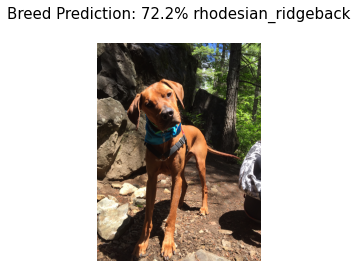

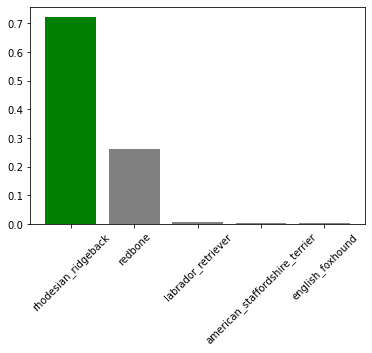

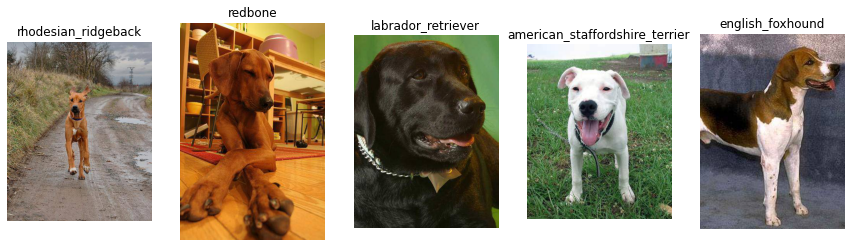

In [82]:
test_dog = 'data/test_dogs/IMG_4463.jpg'
pred_dog = predict_input(test_dog, saved_mobilenet, 'rhodesian_ridgeback', True)

### I wanted to see what the model accuracy is of classifying the correct breed within the top 5 predictions. The function below will calculate that accuracy

In [65]:
def accuracy_within_5(model, test_images, test_labels):
    """
    This function determines the accuract of our model within 5 predictions.
    Aka: how often does our model correctly classify the breed within the top 5 highest predictions

    Parameters
    ----------
    model: inputs the model that we are using to evaluat test images
    test_images: pre-processed images using to evaluate our model on
    test_labels: true corresponding breed labels for each of the test images to use for model evaluation

    Returns
    -------
    returns num_currect/num_test rounded to 2 decimal points
    """
    num_tests = len(test_images)
    num_correct = 0 
    
    # iterate through the test images
    for i in range(num_tests):
        img = test_images[i]
        reshape_image = np.reshape(img, [1, img.shape[0], img.shape[1], 3])
        predictions = np.array(model.predict(reshape_image))
        
        #get top 5 predictions
        top_preds = predictions[0].argsort()[-5:][::-1]
        
        #if correct label is in the top 5, add 1 to number of correct
        if np.argmax(test_labels[i]) in top_preds:
            num_correct += 1
    
    # return as percentage of total number test
    return round(num_correct/num_tests, 2)  

In [78]:
top_accuracy = accuracy_within_5(saved_mobilenet, test_images, test_labels)

print(f"Accuracy of model within top 5 predictions: {top_accuracy*100}%")

Accuracy of model within top 5 predictions: 94.0%


# Conclusion
---

We have created a model that will predict a dog's breed with an accuracy of 78%. Further analysis shows that our model was actually able to classify the correct breed within the top 5 predictions at a 94% accuracy rate. We can conclude that our final model's 78% accuracy is an improvement over the current 67% accuracy of shelter's visual identification.

To guarantee best results, we recommend the input image be good lighting, without any image noise, and presents any distinguishable features of the dog. While testing out images, these types of images had a much higher success rate for being accurately classified. Similarly this model performed much better on images of dogs that are purebred, but still maintained some accuracy for dogs that are mixed-breed. 

# Next Steps
--- 

Given more time and resources I would love to collect more training data so to work towards increasing our models accuracy. While our model has performed relatively well on being able to accurately classify 120 dog breeds, for this model to be the most useful for animal shelters it will have to improve accuracy on any mixed-breed dogs, since more often dogs in shelters are mixed-breed and not purebred. 